In [ ]:
!pip install shap
!pip install lime
!pip install alibi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d5048f2549a41395351bb29d2b7d9a804f38b22a8e40a821d4c6b037026d2d03
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, pr

# Imports & Load of Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime.lime_tabular
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance
from alibi.explainers import ALE, plot_ale

In [ ]:
X_train = pd.read_csv('/content/X_train_final.csv')
X_test = pd.read_csv('/content/X_test_final.csv')
y_train = pd.read_csv('/content/y_train_final.csv').squeeze()
y_test = pd.read_csv('/content/y_test_final.csv').squeeze()

In [ ]:
for df in [X_train, X_test]:
    df.columns = df.columns.str.replace(r"[\[\]\(\),<]", "_", regex=True)
    df.columns = df.columns.str.replace(r"\s+", "_", regex=True)

In [ ]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


HistGradientBoostingClassifier Evaluation
Accuracy: 0.93
Precision: 0.93
Recall: 0.94
F1 Score: 0.94
AUC: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92       544
           1       0.93      0.94      0.94       635

    accuracy                           0.93      1179
   macro avg       0.93      0.93      0.93      1179
weighted avg       0.93      0.93      0.93      1179



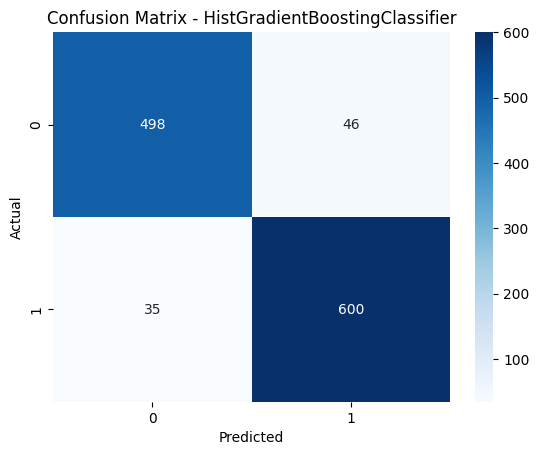

In [ ]:
sgb_model = HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, max_depth=6, random_state=42)
sgb_model.fit(X_train, y_train)
evaluate_model("HistGradientBoostingClassifier", sgb_model, X_test, y_test)

SHAP Summary for SGB


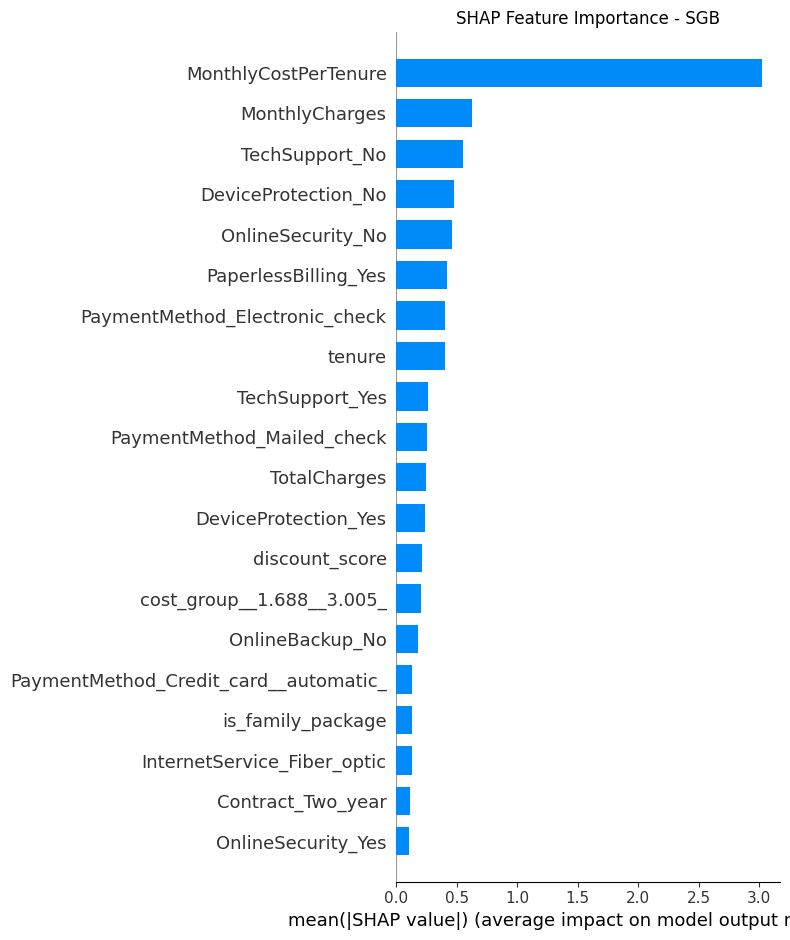

In [ ]:
print("SHAP Summary for SGB")
explainer_sgb = shap.TreeExplainer(sgb_model)
shap_values_sgb = explainer_sgb.shap_values(X_test)
shap.summary_plot(shap_values_sgb, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - SGB")
plt.tight_layout()
plt.show()

The SHAP feature importance plot for the Stochastic Gradient Boosting (SGB) model reveals that MonthlyCostPerTenure is by far the most dominant feature influencing churn predictions. Customers who incur higher monthly charges relative to their tenure are significantly more likely to leave the service.

Other notable contributors include MonthlyCharges, TechSupport_No, DeviceProtection_No, and OnlineSecurity_No, indicating that customers without support services and those paying more are more prone to churn. These features capture both financial burden and the lack of customer care services as key churn signals.

Additionally, features such as PaperlessBilling_Yes, PaymentMethod_Electronic_check, and tenure itself show moderate impact. Their influence suggests that customers with shorter engagement or using transient billing options tend to be more at risk.

In contrast, features like InternetService_Fiber_optic, Contract_Two_year, and OnlineSecurity_Yes exhibit relatively lower SHAP values, implying minimal contribution to churn predictions in this model. Overall, the SGB model relies most on cost efficiency and service availability to determine churn risk.

In [ ]:
print("LIME Explanation for SGB")
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)
explainer_lime = LimeTabularExplainer(X_train_df.values, feature_names=X_train_df.columns.tolist(), class_names=['No Churn', 'Churn'], discretize_continuous=True)
sample_instance = X_test_df.iloc[0]
exp = explainer_lime.explain_instance(sample_instance.values, sgb_model.predict_proba)
exp.show_in_notebook()

LIME Explanation for SGB


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(


The LIME explanation for the Stochastic Gradient Boosting (SGB) model offers a localized interpretation for a specific customer prediction, where the model assigns a 74% probability of churn. The most influential factor driving this prediction is the customer's high MonthlyCostPerTenure (43.80), which significantly increases churn risk. This aligns with global SHAP findings, highlighting cost burden early in the contract as a key churn trigger.

Other churn-contributing features include the absence of TechSupport_No, OnlineSecurity_No, and the use of Electronic check as a payment method—each associated with lower service satisfaction and higher churn risk. In contrast, the presence of TechSupport_Yes, PaperlessBilling_Yes, and DeviceProtection_Yes provided minor offsets, indicating these features slightly reduced churn probability but not enough to override the dominant risk signals.

Overall, this LIME output reinforces the conclusion that cost efficiency and support service availability play pivotal roles in individual churn decisions. The customer in this case is identified as high-risk due to elevated cost-per-tenure and lack of engagement with retention-supportive features.

<ipython-input-15-491f94c79e7e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pfi_df, x='Importance', y='Feature', palette='viridis')


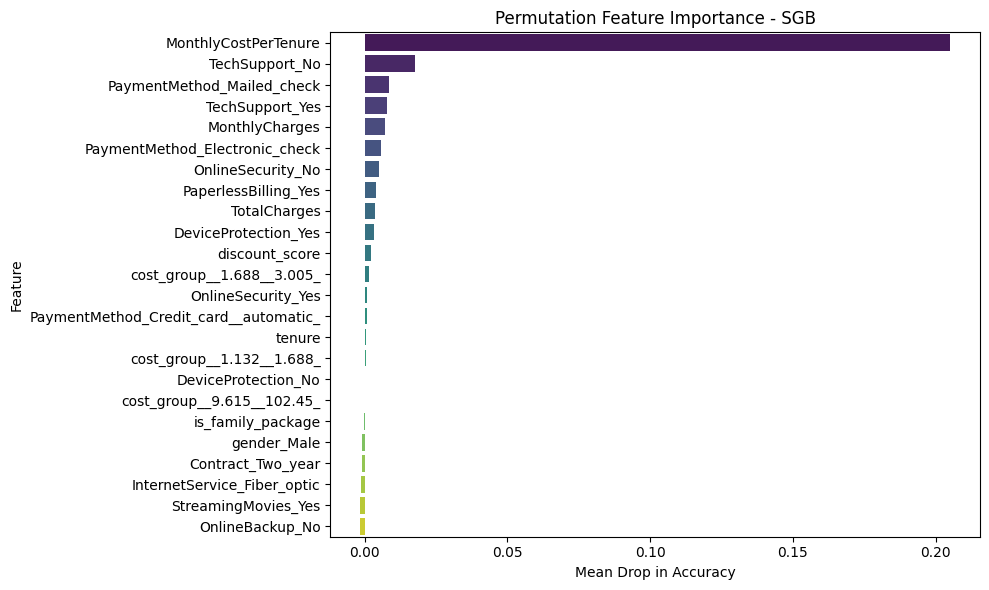

In [ ]:
perm_importance = permutation_importance(sgb_model, X_test, y_test, n_repeats=10, random_state=42)
pfi_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=pfi_df, x='Importance', y='Feature', palette='viridis')
plt.title("Permutation Feature Importance - SGB")
plt.xlabel("Mean Drop in Accuracy")
plt.tight_layout()
plt.show()

The Permutation Feature Importance (PFI) plot for the Stochastic Gradient Boosting model highlights MonthlyCostPerTenure as the most critical feature, showing the highest mean drop in model accuracy when shuffled. This confirms that the model’s ability to predict churn is highly dependent on understanding how much a customer pays relative to their tenure, reinforcing its importance observed in both SHAP and LIME explanations.

Other impactful features include TechSupport_No, PaymentMethod_Mailed_check, and TechSupport_Yes, indicating that support service availability and payment method preferences are essential drivers of model predictions. Features such as MonthlyCharges, OnlineSecurity_No, and Electronic check also contribute moderately, suggesting that customer experience and billing behavior play supportive but secondary roles.

In contrast, several features such as StreamingMovies_Yes, gender_Male, and Contract_Two_year have near-zero importance in the permutation test, suggesting minimal influence on model accuracy. These variables may still add marginal value but are not core to the model’s prediction strategy.

Overall, PFI results confirm that the model relies most heavily on a cost-to-tenure efficiency signal and service usage behavior to distinguish churn-prone customers.

In [ ]:
print("\nALE Explanation for SGB")
ale = ALE(sgb_model.predict_proba, feature_names=X_train.columns.tolist(), target_names=['No Churn', 'Churn'])
ale_exp = ale.explain(X_test.values)


ALE Explanation for SGB


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with f

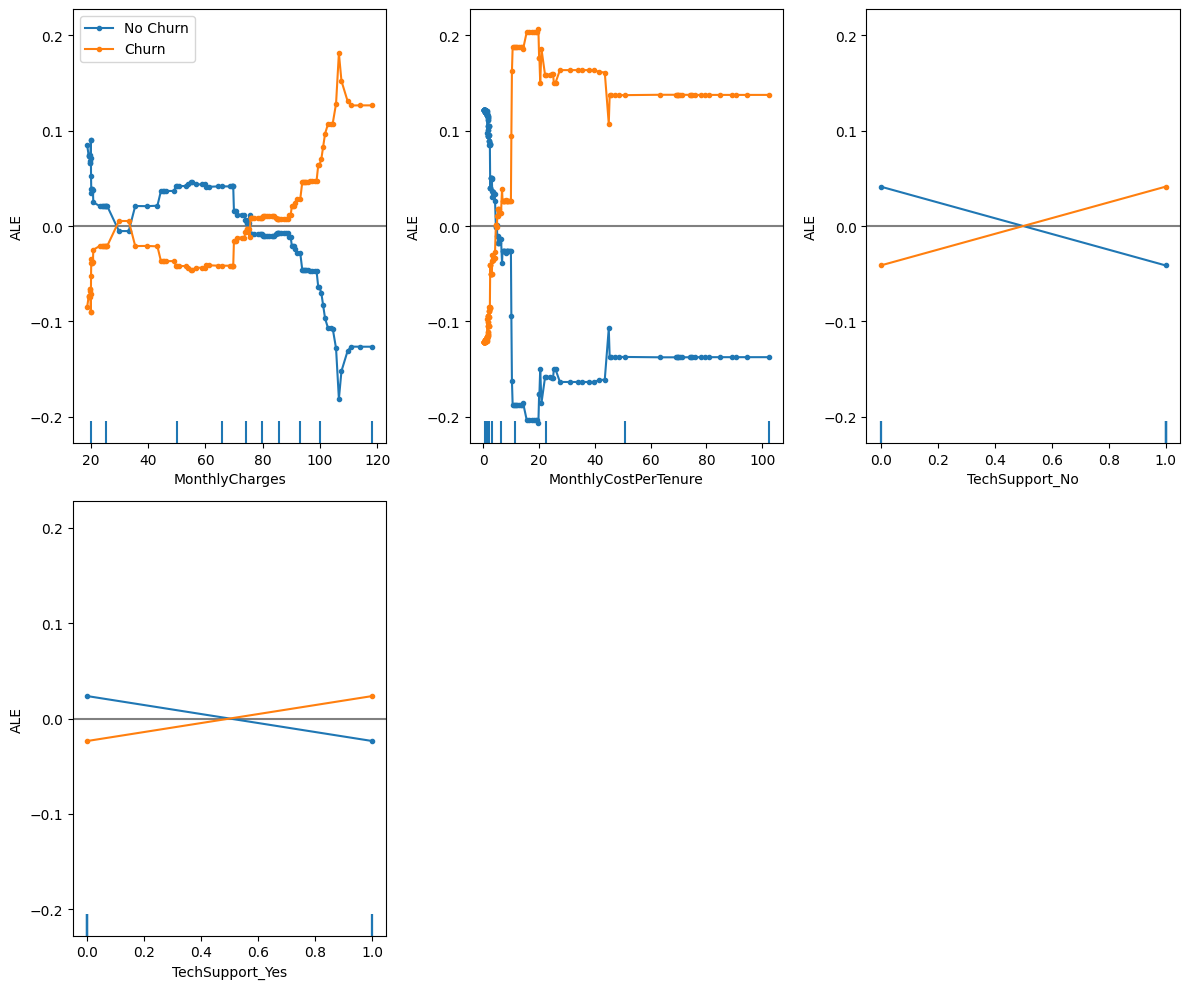

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
plot_ale(ale_exp, features=[4, 5, 14, 15], ax=ax)
plt.show()

The ALE plots provide insight into the average marginal effect of selected features on the churn prediction probability while accounting for interactions and correlations in the dataset. These plots show how each feature influences the predicted probability of churn across different values, separated for the two classes: Churn and No Churn.

1. MonthlyCharges:
* For customers predicted as No Churn, ALE values fluctuate, peaking around mid-range charges (~$50–$60) and decreasing sharply beyond ~$70, suggesting that high charges discourage retention.

* For Churn predictions, there's a mild upward trend in ALE with increasing charges, showing that customers paying more are incrementally more likely to churn.

* This supports the idea that billing sensitivity plays a key role in churn behavior.

2. MonthlyCostPerTenure:
* A steep positive ALE is observed for churn predictions when this feature is low (~0–10), meaning early-stage high-spending customers are at high risk of churn.

* Beyond this early cost phase, the ALE stabilizes or slightly declines, suggesting diminishing marginal risk from this feature.

* The sharp contrast between the two classes at low values confirms this as a powerful predictor of churn.

3. TechSupport_No:
* For customers with no tech support, ALE values increase sharply for Churn and decrease for No Churn, indicating strong separation.

* This implies that absence of support services is strongly associated with churn risk, while presence may help retain customers.

4. TechSupport_Yes:
* The effect is inverse and milder: having tech support slightly lowers churn probability (positive ALE for No Churn, negative for Churn).

* This further validates the conclusion that support availability helps reduce churn risk.

Overall Conclusion:
These ALE plots affirm that the SGB model relies heavily on early financial pressure (MonthlyCostPerTenure), customer service access (TechSupport), and billing behavior (MonthlyCharges) when forming churn predictions.